# Clustering

Check this [link](https://www.geeksforgeeks.org/clustering-in-machine-learning/) to get an idea of what is clustering in general.

Most of the time we read the clusterring algorithims as a unsupervised learning method, not knowing where it can be used in real world at first. As part of our playground example, we have collected tweets that talks about Data Science/AI. Lets use clustering texhniques to see how the collected data is distributed.

Lets create our own custom Sckilearn transformers and estimators like mentioned [here](https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65), the advantage of doing so is that it enables us to resuse our preprocessing and postprocessing logic across data splits and for new data alike.

There is no cluttering of code and the error of missing some or other preprocessing routines. 

## Must Read Topics
- KL Divergence
    - https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-kl-divergence-2b382ca2b2a8

**For those who spend more time with Deep Learning, the methods that are been used here, may seem litle strange or loss of information with data preprocessing and dimensionality reduction, and the reason is, most of the ML algorithms depends on statistical and probability nature of the data, less noise the better. Put it simply, most of the ML algorithms takes the advantages of the randomeness and their distribution of the data that really makes sense, and asking machines to fit a mathematical formula for it! and use the formula (model) to predict it. Deep Learning models also does same but with many neurons, thats where the difference lies, ok okay... lets not get into that debate. We have less data and hence no Deep Learning, does that make sense? Ok I heard the conversation/mind voice, we use Twitter stream why less data? basically I am lazy and don't wanna deal huge dataset for educational purpose....hehe**

In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import imageio
plt.style.use('ggplot')
import json
import re
import nltk
# nltk.download('punkt')
import spacy
import textacy
import numpy as np
import sys
from tqdm import tqdm, tqdm_notebook
# tqdm.pandas()
sys.path.append("../src/")

import random
"""
Its important to set random seed to reproduce the results.
"""
random_state = 42
random.seed(random_state)
np.random.seed(random_state)

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import FeatureUnion, Pipeline 

from ssp.ml.estimator import TextFeatureEngineering
from ssp.ml.transformer import TextPreProcessor
from ssp.ml.transformer import SSPTextLabeler
from ssp.viz.word_cloud import plot_word_cloud

# *Note: some import may not make sense as I may have forgot to remove it as I do more experiments here!

[ssp.ml.estimator]("../../../src/ssp/ml/estimator")   
[ssp.ml.transformer]("../../../src/ssp/ml/transformer") 

In [7]:
ls ~/ssp/data/dump/raw_tweet_dataset_0/

dev.parquet  snorkel_train_df.parquet  test.parquet  train.parquet


In [2]:
TEXT_COL="text"
TEXT_PROCESSED_COL = "text_processed"
TEXT_FEATURE_ENG_COL = "text_num_features"
ssp_LF_dataset = pd.read_parquet("~/ssp/data/dump/raw_tweet_dataset_0/test.parquet", engine="fastparquet")

Lets do a wordcloud plot and see what are dominating keywords

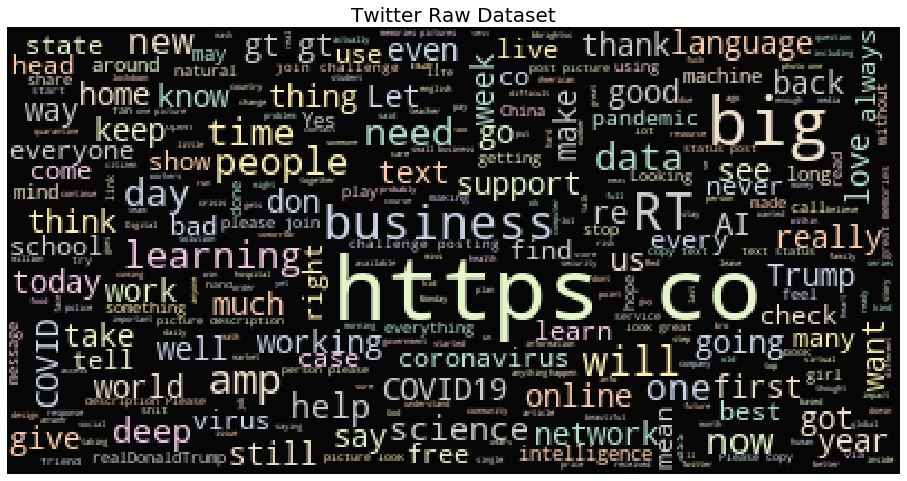

In [3]:
plot_word_cloud(df=ssp_LF_dataset, text_col=TEXT_COL)

Looks like there are lot of http links in the tweets, making it to come up in the top 100 keywords. 
Should we consider "https" and "co" in our vocabalary? can it add some meaning to our text classification?
Both Data Science/AI and other tweets are gonna have this keyword and its not going to be any use!

Then why to keep it, lets remove it. :)

## Data Preprocessing
All our data pre-processing logic is encapsulated under this transformer! Check the source code for more details

In [4]:
text_preprocessor_transformer = TextPreProcessor(input_col=TEXT_COL, output_col=TEXT_PROCESSED_COL)

In [5]:
ssp_LF_dataset = text_preprocessor_transformer.transform(ssp_LF_dataset)
ssp_LF_dataset 

,id_str,created_at,source,text,expanded_url,media_url_https,hash,naive_label,id,text_processed
0,1244622697352527872,Mon Mar 30 13:49:09 +0000 2020,Twitter for Android,I would love an anime about programming like h...,[],None,95eee60ddde04fe2eace6f0e1d162835bcb7adc4a11d41...,1,0,pron love anime programming hataraku saibou co...
1,1244627764960878592,Mon Mar 30 14:09:17 +0000 2020,Instagram,supply.Big Quantity 3ply FaceMask#3plyFaceMask...,"[http://www.3plyFaceMaskChina.com, https://www...",None,51f5a68648b00850075c0818fc4f951ee12f4b7c18b4ac...,0,1,supply big quantity 3ply facemask3plyfacemask
2,1244627826596294665,Mon Mar 30 14:09:32 +0000 2020,Twitter for iPhone,If you are a Rugby League person please join t...,[https://twitter.com/i/web/status/124462782659...,None,962ddd43a915ed6f432481161fd585f8607c49f2c5d735...,1,2,if rugby league person join challenge post rl ...
3,1244624922833555456,Mon Mar 30 13:58:00 +0000 2020,Twitter Web App,@S_h_e_e_n_a_ I like that you give primacy to ...,[https://twitter.com/i/web/status/124462492283...,None,42670aac877b42c71c80c58006623c3f3c641b9cd27a6a...,1,3,pron primacy reality amp pron think love compl...
4,1244622758090289152,Mon Mar 30 13:49:24 +0000 2020,Twitter for Android,Dear @myogiadityanath @CMOfficeUP you're worki...,[],None,c34115252207194271c208248ebef1c047fce1dd942a88...,1,4,dear work extremely hard week control coronain...
...,...,...,...,...,...,...,...,...,...,...
995,1244623942033301505,Mon Mar 30 13:54:06 +0000 2020,Twitter for Android,A big big warm hug for all the sidhearts from ...,[https://twitter.com/i/web/status/124462394203...,None,64d2a567a7a1ece4d022662437d6a76e9c58b2601ef494...,1,995,a big big warm hug sidheart shehzaain trend sa...
996,1244622848364285952,Mon Mar 30 13:49:45 +0000 2020,Twitter for iPhone,@melissadderosa Science and numbers do not lie!,[],None,4cc2f04d6109277ffc9830d45d01a4485f185c3f2d0702...,0,996,science number lie
997,1244624727781580802,Mon Mar 30 13:57:13 +0000 2020,Twitter for Android,💚 THANK YOU 💚We'd like to say a MASSIVE thanks...,[],None,f1f6e8c5430de22f06985b462b1f696c0f35da6f60a2b4...,1,997,thank you pron massive thank pack deliver food...
998,1244625092044341249,Mon Mar 30 13:58:40 +0000 2020,ElectronicSheepForInsomniacs,Facebook failed to investigate The Daily Wire'...,[http://www.businessinsider.com/facebook-daily...,None,1069bddacb2b2a571caf1a858d6978752cf1c3940b4087...,0,998,facebook fail investigate the daily wire misin...


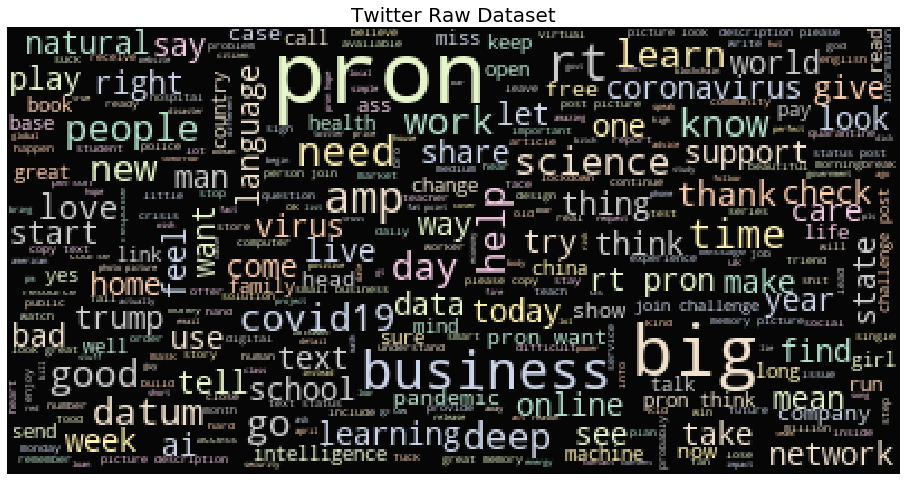

In [6]:
plot_word_cloud(df=ssp_LF_dataset, text_col=TEXT_PROCESSED_COL)

#https://medium.com/reputation-com-datascience-blog/keywords-extraction-with-ngram-and-modified-skip-gram-based-on-spacy-14e5625fce23

## Mannual Tagging Programmatically

Lets label our data based on our prior knowledge of the data, that is if the tweet contains any of pre defined Data SCience/AI 
key words lets consider it talks about AI

In [7]:
ssp_labeler = SSPTextLabeler(input_col=TEXT_PROCESSED_COL)

In [8]:
ssp_LF_dataset = ssp_labeler.transform(ssp_LF_dataset)


0    899
1    101
Name: label, dtype: int64


In [9]:
ssp_LF_dataset[TEXT_PROCESSED_COL].values[0]

'pron love anime programming hataraku saibou computer'

## Feature Extraction/Engineering

Computer processors needs numeric data, but we have text data with us, so someone has to do the conversion right? Feature engineering is the fancy ;) term that encapsulates some standart methods to convert text data into numeric data and lot of ad-hoc methods to extract meaning full numerica data out of text (for example number of punctuations, number of positive words and negative words, etc.,)

- [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
![](../../../docs/images/count_vec.png)

```
0 - HIVE
1 - JAVA
2 - SQL
3 - PYTHON

Index: [0, 1, 2, 3]
Doc1 : [2, 0, 0, 1]
Doc2 : [0, 2, 1, 0]
```
More info [here](https://towardsdatascience.com/countvectorizer-hashingtf-e66f169e2d4e)

- [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

![](../../../docs/images/tdidf.png)

More info [here](https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76)

In [10]:


text_feature_eng_transformer = TextFeatureEngineering(input_col=TEXT_PROCESSED_COL, 
                                                      output_col=TEXT_FEATURE_ENG_COL,
                                                      vectorizer = "tfidf",
                                                      max_features=4096, 
                                                      ngram_range=(2, 2))

In [11]:
text_feature_eng_transformer = text_feature_eng_transformer.fit(ssp_LF_dataset)
text_numerical_features = text_feature_eng_transformer.transform(ssp_LF_dataset)

In [12]:
text_numerical_features.shape

(1000, 4750)

### Dimensionality Reduction

Now we have extracted enough features for our training, but can we work with such high dimensional data? 
Dependending on the number of records the answer is yes/no. Considering the answer is no, as our systems can't hold huge arrays, lets reduce the features?

But wait? how do we know which one should keep and which should throw away?

Lets give that jobs to dimensionality reductions models/algorithms which can do it in more statistical way.

- [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [13]:
tsne = TSNE(verbose=1, perplexity=30, n_components=2)
text_numerical_features_2_dim = tsne.fit_transform(text_numerical_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.089s...
[t-SNE] Computed neighbors for 1000 samples in 7.973s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.500067
[t-SNE] KL divergence after 250 iterations with early exaggeration: 157.710541
[t-SNE] KL divergence after 1000 iterations: 4.831066


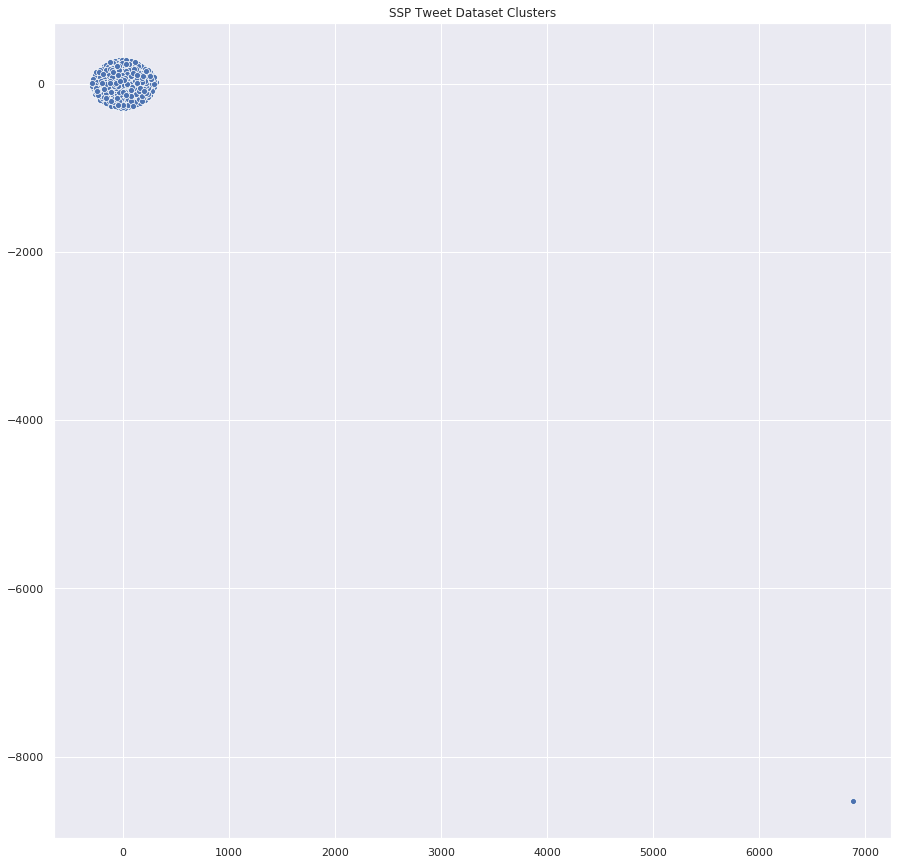

In [14]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})
# colors
palette = sns.color_palette("bright", 1)
# plot
sns.scatterplot(text_numerical_features_2_dim[:,0], text_numerical_features_2_dim[:,1], palette=palette)
plt.title("SSP Tweet Dataset Clusters")
plt.show()

 - PCA

In [15]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
pca_features = pca.fit_transform(text_numerical_features)

# reduce the cluster centers to 2D
pca_reduced_features = pca.transform(text_numerical_features)


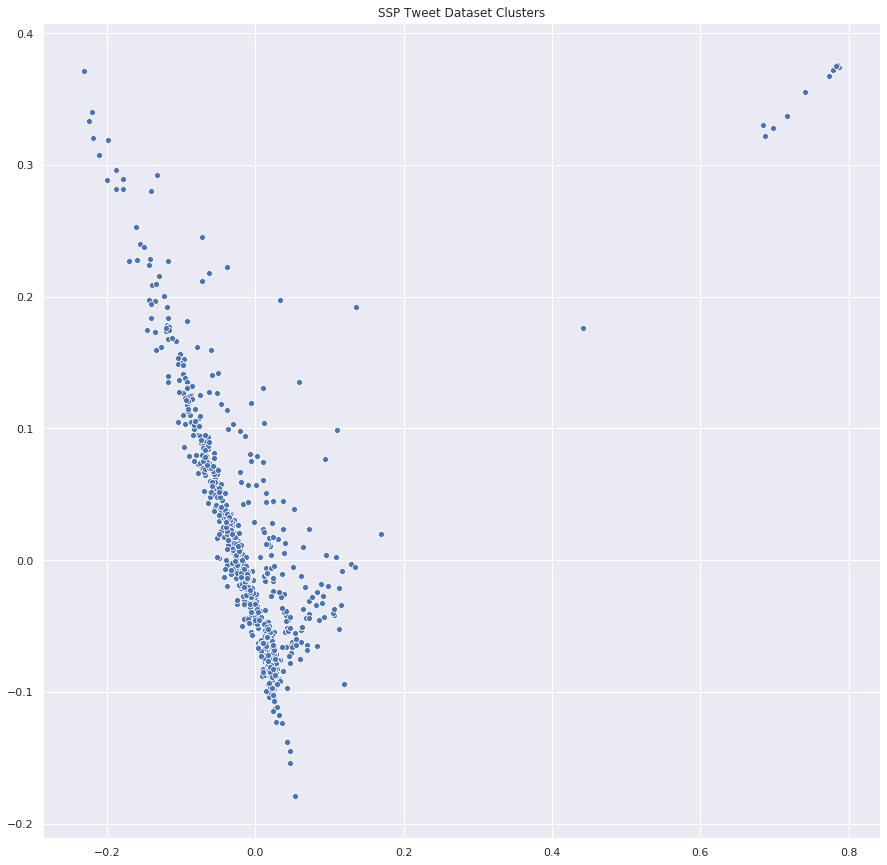

In [16]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})
# colors
palette = sns.color_palette("bright", 1)
# plot
sns.scatterplot(pca_reduced_features[:,0], pca_reduced_features[:,1], palette=palette)
plt.title("SSP Tweet Dataset Clusters")
plt.show()

In [17]:
# LDA

## KMeans
- https://www.geeksforgeeks.org/k-means-clustering-introduction/

In [20]:
k = 2
kmeans = KMeans(n_clusters=k, init='k-means++', n_jobs=4, verbose=10)
y_pred = kmeans.fit_predict(text_numerical_features)
kmeans_clusters = kmeans.cluster_centers_

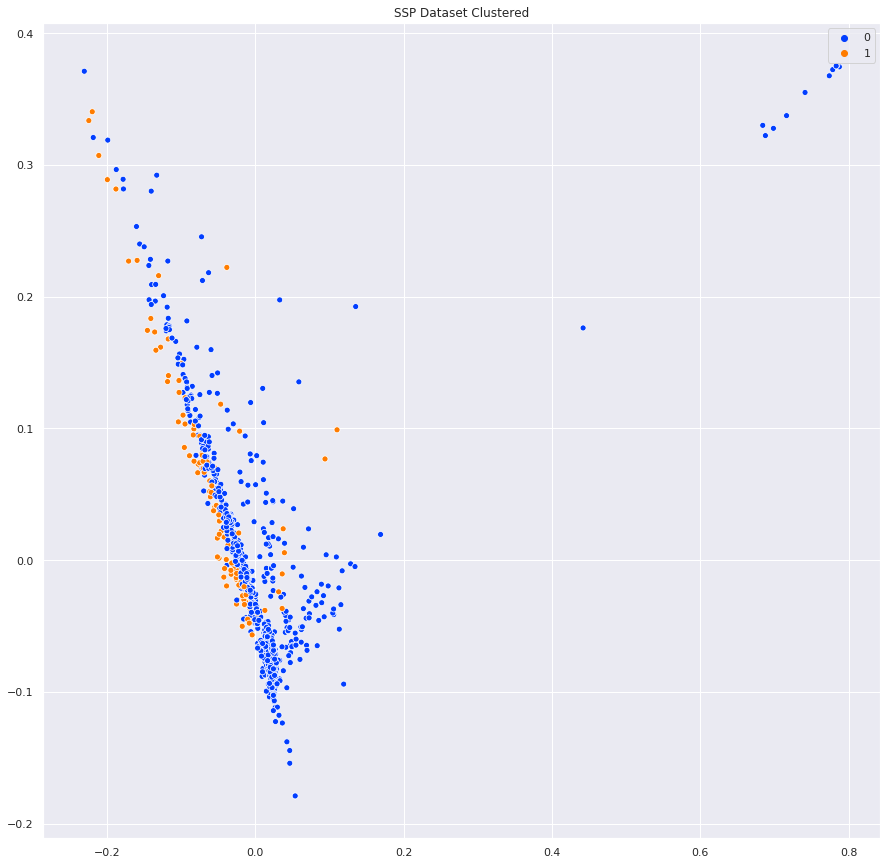

In [21]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})
# colors
palette = sns.color_palette("bright", len(set(y_pred)))
# plot
sns.scatterplot(pca_reduced_features[:,0], pca_reduced_features[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("SSP Dataset Clustered")
plt.show()

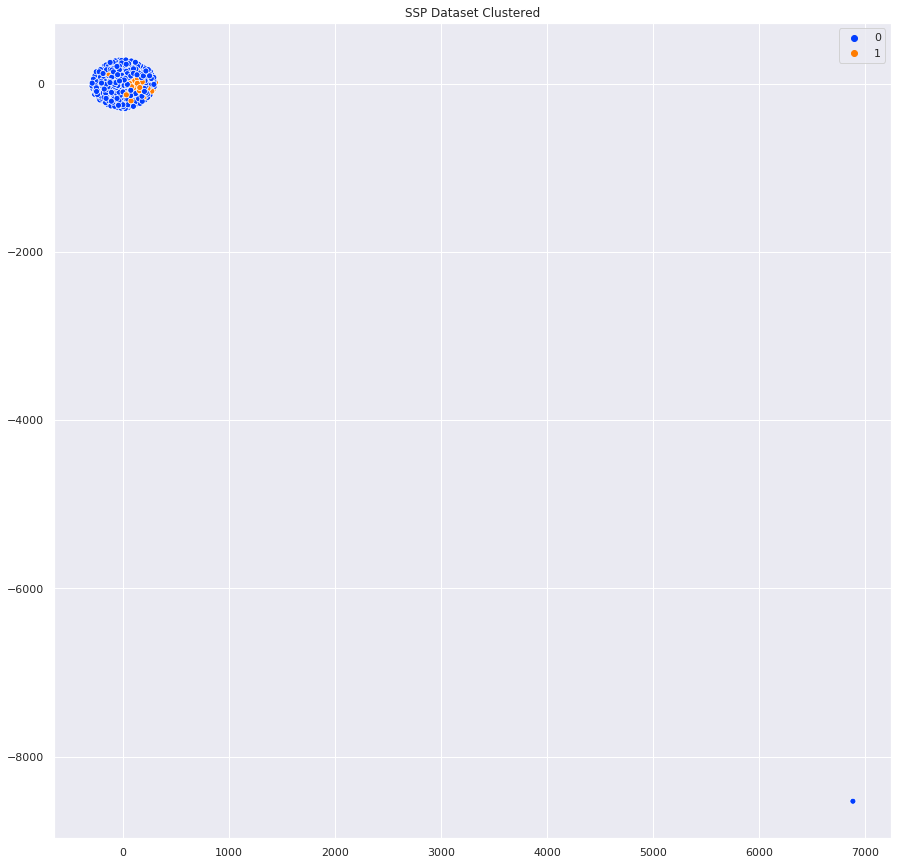

In [22]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})
# colors
palette = sns.color_palette("bright", len(set(y_pred)))
# plot
sns.scatterplot(text_numerical_features_2_dim[:,0], text_numerical_features_2_dim[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("SSP Dataset Clustered")
plt.show()

In [23]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
# order_centroids[0, :10]

In [24]:
terms = text_feature_eng_transformer.get_feature_names()
for i in range(2):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Cluster 0:
 pron
 big
 business
 time
 need
 amp
 science
 deep
 work
 people
Cluster 1:
 rt
 big
 pron
 learn
 deep
 science
 text
 need
 business
 dick


In [25]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')


NameError: name 'reduced_features' is not defined

In [54]:
# terms

In [20]:
# LDA -> KMeans

In [21]:
# Clustering Validation Metrics
# siloutte score
# perplexicity 

**References**
- https://www.kaggle.com/maksimeren/covid-19-literature-clustering
- Understanding a bit of precision and recall is very important for the classification
    - https://towardsdatascience.com/precision-vs-recall-386cf9f89488
    - https://medium.com/@mlengineer/generative-and-discriminative-models-af5637a66a3